# **Homework 5** Problem 2

## (a) Prepare Dataset

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
%cd /content/gdrive/MyDrive/UW/EEP596/HW5
!unzip gtzan.zip

## (b) Audio Feature Extraction

In [2]:
%cd /content
data_root = "/content/gdrive/MyDrive/UW/EEP596/HW5/gtzan"

/content


In [3]:
!ls

gdrive	sample_data


In [4]:
import librosa
import math
import os
import re
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import random

class GenreFeatureData:

    "Music audio features for genre classification"
    hop_length = None
    genre_list = [
        "classical",
        "country",
        "disco",
        "hiphop",
        "jazz",
        "metal",
        "pop",
        "reggae",
    ]

    dir_trainfolder = os.path.join(data_root, "_train")
    dir_devfolder = os.path.join(data_root, "_validation")
    dir_testfolder = os.path.join(data_root, "_test")
    dir_all_files = data_root

    train_X_preprocessed_data = os.path.join(data_root, "data_train_input.npy")
    train_Y_preprocessed_data = os.path.join(data_root, "data_train_target.npy")
    dev_X_preprocessed_data = os.path.join(data_root, "data_validation_input.npy")
    dev_Y_preprocessed_data = os.path.join(data_root, "data_validation_target.npy")
    test_X_preprocessed_data = os.path.join(data_root, "data_test_input.npy")
    test_Y_preprocessed_data = os.path.join(data_root, "data_test_target.npy")

    train_X = train_Y = None
    dev_X = dev_Y = None
    test_X = test_Y = None

    def __init__(self):
        self.hop_length = 512

        self.timeseries_length_list = []
        self.trainfiles_list = self.path_to_audiofiles(self.dir_trainfolder)
        self.devfiles_list = self.path_to_audiofiles(self.dir_devfolder)
        self.testfiles_list = self.path_to_audiofiles(self.dir_testfolder)

        self.all_files_list = []
        self.all_files_list.extend(self.trainfiles_list)
        self.all_files_list.extend(self.devfiles_list)
        self.all_files_list.extend(self.testfiles_list)

        # compute minimum timeseries length, slow to compute, caching pre-computed value of 1290
        # self.precompute_min_timeseries_len()
        # print("min(self.timeseries_length_list) ==" + str(min(self.timeseries_length_list)))
        # self.timeseries_length = min(self.timeseries_length_list)

        self.timeseries_length = (
            128
        )   # sequence length == 128, default fftsize == 2048 & hop == 512 @ SR of 22050
        #  equals 128 overlapped windows that cover approx ~3.065 seconds of audio, which is a bit small!

    def load_preprocess_data(self):
        print("[DEBUG] total number of files: " + str(len(self.timeseries_length_list)))

        # Training set
        self.train_X, self.train_Y = self.extract_audio_features(self.trainfiles_list)
        with open(self.train_X_preprocessed_data, "wb") as f:
            np.save(f, self.train_X)
        with open(self.train_Y_preprocessed_data, "wb") as f:
            self.train_Y = self.one_hot(self.train_Y)
            np.save(f, self.train_Y)

        # Validation set
        self.dev_X, self.dev_Y = self.extract_audio_features(self.devfiles_list)
        with open(self.dev_X_preprocessed_data, "wb") as f:
            np.save(f, self.dev_X)
        with open(self.dev_Y_preprocessed_data, "wb") as f:
            self.dev_Y = self.one_hot(self.dev_Y)
            np.save(f, self.dev_Y)

        # Test set
        self.test_X, self.test_Y = self.extract_audio_features(self.testfiles_list)
        with open(self.test_X_preprocessed_data, "wb") as f:
            np.save(f, self.test_X)
        with open(self.test_Y_preprocessed_data, "wb") as f:
            self.test_Y = self.one_hot(self.test_Y)
            np.save(f, self.test_Y)

    def load_deserialize_data(self):

        self.train_X = np.load(self.train_X_preprocessed_data)
        self.train_Y = np.load(self.train_Y_preprocessed_data)

        self.dev_X = np.load(self.dev_X_preprocessed_data)
        self.dev_Y = np.load(self.dev_Y_preprocessed_data)

        self.test_X = np.load(self.test_X_preprocessed_data)
        self.test_Y = np.load(self.test_Y_preprocessed_data)

    def precompute_min_timeseries_len(self):
        for file in self.all_files_list:
            print("Loading " + str(file))
            y, sr = librosa.load(file)
            self.timeseries_length_list.append(math.ceil(len(y) / self.hop_length))

    def MFCC_Chrimagram_Figure(self, list_of_audiofiles = None):
        list_of_audiofiles = self.trainfiles_list 
        print(list_of_audiofiles)
        random.seed = 2
        sample = random.sample(range(0,len(list_of_audiofiles)),1)
        data,sr = librosa.load(list_of_audiofiles[sample[0]])
        mfccs = librosa.feature.mfcc(data, sr=sr)
        chroma = librosa.feature.chroma_stft(y=data, sr=sr, hop_length=self.hop_length)
        # Displaying the MFCCs:
        fig, ax = plt.subplots()
        librosa.display.specshow(mfccs, sr=sr, x_axis='time', ax=ax )
        ax.set(title='MFCCs')
        # Displaying the Chromagram:
        fig, ax = plt.subplots()
        librosa.display.specshow(chroma, sr=sr, x_axis='time',ax=ax)
        ax.set(title='Chromagram')
        return None

    def extract_audio_features(self, list_of_audiofiles):

        data = np.zeros(
            (len(list_of_audiofiles), self.timeseries_length, 33), dtype=np.float64
        )
        target = []

        for i, file in enumerate(list_of_audiofiles):
            y, sr = librosa.load(file)
            mfcc = librosa.feature.mfcc(
                y=y, sr=sr, hop_length=self.hop_length, n_mfcc=13
            )
            spectral_center = librosa.feature.spectral_centroid(
                y=y, sr=sr, hop_length=self.hop_length
            )
            chroma = librosa.feature.chroma_stft(y=y, sr=sr, hop_length=self.hop_length)
            spectral_contrast = librosa.feature.spectral_contrast(
                y=y, sr=sr, hop_length=self.hop_length
            )

            splits = re.split("[ .]", file)
            genre = re.split("[ /]", splits[0])[-1]
            target.append(genre)

            data[i, :, 0:13] = mfcc.T[0:self.timeseries_length, :]
            data[i, :, 13:14] = spectral_center.T[0:self.timeseries_length, :]
            data[i, :, 14:26] = chroma.T[0:self.timeseries_length, :]
            data[i, :, 26:33] = spectral_contrast.T[0:self.timeseries_length, :]

            print(
                "Extracted features audio track %i of %i."
                % (i + 1, len(list_of_audiofiles))
            )

        return data, np.expand_dims(np.asarray(target), axis=1)

    def one_hot(self, Y_genre_strings):
        y_one_hot = np.zeros((Y_genre_strings.shape[0], len(self.genre_list)))
        for i, genre_string in enumerate(Y_genre_strings):
            index = self.genre_list.index(genre_string)
            y_one_hot[i, index] = 1
        return y_one_hot

    @staticmethod
    def path_to_audiofiles(dir_folder):
        list_of_audio = []
        for file in os.listdir(dir_folder):
            if file.endswith(".au"):
                directory = "%s/%s" % (dir_folder, file)
                list_of_audio.append(directory)
        return list_of_audio

## (c) LSTM Implementation

Print out the dimension of training features, valiation features, and test features, as well as the ground truths.

Visualize MFCC and Chromagram features.

Visualize loss during the training.

In [5]:
model = None
genre_features = None
genre_features = GenreFeatureData()
genre_features.load_preprocess_data()

[DEBUG] total number of files: 0
Extracted features audio track 1 of 420.
Extracted features audio track 2 of 420.
Extracted features audio track 3 of 420.
Extracted features audio track 4 of 420.
Extracted features audio track 5 of 420.
Extracted features audio track 6 of 420.
Extracted features audio track 7 of 420.
Extracted features audio track 8 of 420.
Extracted features audio track 9 of 420.
Extracted features audio track 10 of 420.
Extracted features audio track 11 of 420.
Extracted features audio track 12 of 420.
Extracted features audio track 13 of 420.
Extracted features audio track 14 of 420.
Extracted features audio track 15 of 420.
Extracted features audio track 16 of 420.
Extracted features audio track 17 of 420.
Extracted features audio track 18 of 420.
Extracted features audio track 19 of 420.
Extracted features audio track 20 of 420.
Extracted features audio track 21 of 420.
Extracted features audio track 22 of 420.
Extracted features audio track 23 of 420.
Extracted 

Training X shape: (420, 128, 33)
Training Y shape: (420, 8)
Validation X shape: (120, 128, 33)
Validation Y shape: (120, 8)
Test X shape: (60, 128, 33)
Test Y shape: (60, 8)
['/content/gdrive/MyDrive/UW/EEP596/HW5/gtzan/_train/classical.00032.au', '/content/gdrive/MyDrive/UW/EEP596/HW5/gtzan/_train/classical.00031.au', '/content/gdrive/MyDrive/UW/EEP596/HW5/gtzan/_train/classical.00034.au', '/content/gdrive/MyDrive/UW/EEP596/HW5/gtzan/_train/classical.00030.au', '/content/gdrive/MyDrive/UW/EEP596/HW5/gtzan/_train/classical.00033.au', '/content/gdrive/MyDrive/UW/EEP596/HW5/gtzan/_train/classical.00036.au', '/content/gdrive/MyDrive/UW/EEP596/HW5/gtzan/_train/classical.00041.au', '/content/gdrive/MyDrive/UW/EEP596/HW5/gtzan/_train/classical.00043.au', '/content/gdrive/MyDrive/UW/EEP596/HW5/gtzan/_train/classical.00037.au', '/content/gdrive/MyDrive/UW/EEP596/HW5/gtzan/_train/classical.00040.au', '/content/gdrive/MyDrive/UW/EEP596/HW5/gtzan/_train/classical.00042.au', '/content/gdrive/MyDri

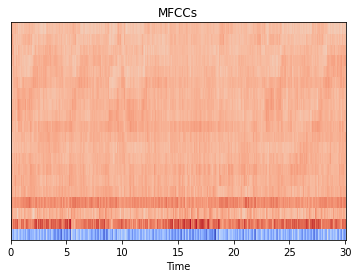

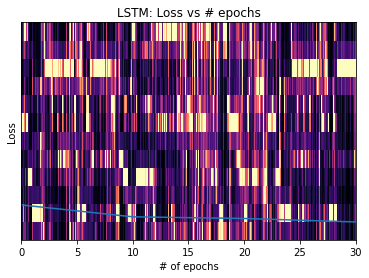

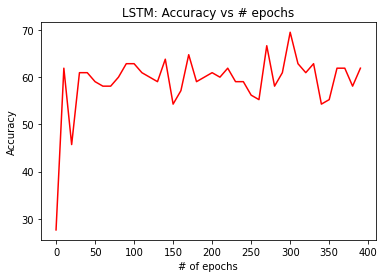

In [6]:
import os
import matplotlib.pyplot as plt
import librosa.display
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, batch_size, output_dim=8, num_layers=2):
        super(LSTM, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.batch_size = batch_size
        self.num_layers = num_layers

        # setup LSTM layer
        self.lstm = nn.LSTM(self.input_dim, self.hidden_dim, self.num_layers)

        # setup output layer
        self.linear = nn.Linear(self.hidden_dim, output_dim)

    def forward(self, input, hidden=None):
        # lstm step => then ONLY take the sequence's final timetep to pass into the linear/dense layer
        # Note: lstm_out contains outputs for every step of the sequence we are looping over (for BPTT)
        # but we just need the output of the last step of the sequence, aka lstm_out[-1]
        lstm_out, hidden = self.lstm(input, hidden)
        logits = self.linear(lstm_out[-1])              # equivalent to return_sequences=False from Keras
        genre_scores = F.log_softmax(logits, dim=1)
        return genre_scores, hidden

    def get_accuracy(self, logits, target):
        """ compute accuracy for training round """
        corrects = (
                torch.max(logits, 1)[1].view(target.size()).data == target.data
        ).sum()
        accuracy = 100.0 * corrects / self.batch_size
        return accuracy.item()

def main():

    train_X = torch.from_numpy(genre_features.train_X).type(torch.Tensor)
    dev_X = torch.from_numpy(genre_features.dev_X).type(torch.Tensor)
    test_X = torch.from_numpy(genre_features.test_X).type(torch.Tensor)

    # Targets is a long tensor of size (N,) which tells the true class of the sample.
    train_Y = torch.from_numpy(genre_features.train_Y).type(torch.LongTensor)
    dev_Y = torch.from_numpy(genre_features.dev_Y).type(torch.LongTensor)
    test_Y = torch.from_numpy(genre_features.test_Y).type(torch.LongTensor)

    # Convert {training, test} torch.Tensors
    print("Training X shape: " + str(genre_features.train_X.shape))
    print("Training Y shape: " + str(genre_features.train_Y.shape))
    print("Validation X shape: " + str(genre_features.dev_X.shape))
    print("Validation Y shape: " + str(genre_features.dev_Y.shape))
    print("Test X shape: " + str(genre_features.test_X.shape))
    print("Test Y shape: " + str(genre_features.test_Y.shape))

    genre_features.MFCC_Chrimagram_Figure()

    batch_size = 35  # num of training examples per minibatch
    num_epochs = 400
    global model
    # Define model
    print("Build LSTM RNN model ...")
    model = LSTM(
        input_dim=33, hidden_dim=128, batch_size=batch_size, output_dim=8, num_layers=2
    )
    loss_function = nn.NLLLoss()  # expects ouputs from LogSoftmax

    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # To keep LSTM stateful between batches, you can set stateful = True, which is not suggested for training
    stateful = False

    train_on_gpu = torch.cuda.is_available()
    if train_on_gpu:
        print("\nTraining on GPU")
    else:
        print("\nNo GPU, training on CPU")

    # all training data (epoch) / batch_size == num_batches (12)
    num_batches = int(train_X.shape[0] / batch_size)
    num_dev_batches = int(dev_X.shape[0] / batch_size)

    val_loss_list, val_accuracy_list, epoch_list = [], [], []

    print("Training ...")
    for epoch in range(num_epochs):

        train_running_loss, train_acc = 0.0, 0.0

        # Init hidden state - if you don't want a stateful LSTM (between epochs)
        hidden_state = None
        for i in range(num_batches):

            # zero out gradient, so they don't accumulate btw batches
            model.zero_grad()

            # train_X shape: (total # of training examples, sequence_length, input_dim)
            # train_Y shape: (total # of training examples, # output classes)
            #
            # Slice out local minibatches & labels => Note that we *permute* the local minibatch to
            # match the PyTorch expected input tensor format of (sequence_length, batch size, input_dim)
            X_local_minibatch, y_local_minibatch = (
                train_X[i * batch_size: (i + 1) * batch_size, ],
                train_Y[i * batch_size: (i + 1) * batch_size, ],
            )

            # Reshape input & targets to "match" what the loss_function wants
            X_local_minibatch = X_local_minibatch.permute(1, 0, 2)

            # NLLLoss does not expect a one-hot encoded vector as the target, but class indices
            y_local_minibatch = torch.max(y_local_minibatch, 1)[1]

            y_pred, hidden_state = model(X_local_minibatch, hidden_state)  # forward pass

            # Stateful = False for training. Do we go Stateful = True during inference/prediction time?
            if not stateful:
                hidden_state = None
            else:
                h_0, c_0 = hidden_state
                h_0.detach_(), c_0.detach_()
                hidden_state = (h_0, c_0)

            loss = loss_function(y_pred, y_local_minibatch)  # compute loss
            loss.backward()  # backward pass
            optimizer.step()  # parameter update

            train_running_loss += loss.detach().item()  # unpacks the tensor into a scalar value
            train_acc += model.get_accuracy(y_pred, y_local_minibatch)

        print(
            "Epoch:  %d | NLLoss: %.4f | Train Accuracy: %.2f"
            % (epoch, train_running_loss / num_batches, train_acc / num_batches)
        )

        if epoch % 10 == 0:
            print("Validation ...")  # should this be done every N=10 epochs
            val_running_loss, val_acc = 0.0, 0.0

            # Compute validation loss, accuracy. Use torch.no_grad() & model.eval()
            with torch.no_grad():
                model.eval()

                hidden_state = None
                for i in range(num_dev_batches):
                    X_local_validation_minibatch, y_local_validation_minibatch = (
                        dev_X[i * batch_size: (i + 1) * batch_size, ],
                        dev_Y[i * batch_size: (i + 1) * batch_size, ],
                    )
                    X_local_minibatch = X_local_validation_minibatch.permute(1, 0, 2)
                    y_local_minibatch = torch.max(y_local_validation_minibatch, 1)[1]

                    y_pred, hidden_state = model(X_local_minibatch, hidden_state)
                    if not stateful:
                        hidden_state = None

                    val_loss = loss_function(y_pred, y_local_minibatch)

                    val_running_loss += (
                        val_loss.detach().item()
                    )  # unpacks the tensor into a scalar value
                    val_acc += model.get_accuracy(y_pred, y_local_minibatch)

                model.train()  # reset to train mode after iterationg through validation data
                print(
                    "Epoch:  %d | NLLoss: %.4f | Train Accuracy: %.2f | Val Loss %.4f  | Val Accuracy: %.2f"
                    % (
                        epoch,
                        train_running_loss / num_batches,
                        train_acc / num_batches,
                        val_running_loss / num_dev_batches,
                        val_acc / num_dev_batches,
                    )
                )

            epoch_list.append(epoch)
            val_accuracy_list.append(val_acc / num_dev_batches)
            val_loss_list.append(val_running_loss / num_dev_batches)

    # visualization loss
    plt.plot(epoch_list, val_loss_list)
    plt.xlabel("# of epochs")
    plt.ylabel("Loss")
    plt.title("LSTM: Loss vs # epochs")
    plt.show()

    # visualization accuracy
    plt.plot(epoch_list, val_accuracy_list, color="red")
    plt.xlabel("# of epochs")
    plt.ylabel("Accuracy")
    plt.title("LSTM: Accuracy vs # epochs")
    # plt.savefig('graph.png')
    plt.show()


if __name__ == "__main__":
    main()

In [9]:
train_X = torch.from_numpy(genre_features.train_X).type(torch.Tensor)
dev_X = torch.from_numpy(genre_features.dev_X).type(torch.Tensor)
test_X = torch.from_numpy(genre_features.test_X).type(torch.Tensor)

# Targets is a long tensor of size (N,) which tells the true class of the sample.
train_Y = torch.from_numpy(genre_features.train_Y).type(torch.LongTensor)
dev_Y = torch.from_numpy(genre_features.dev_Y).type(torch.LongTensor)
test_Y = torch.from_numpy(genre_features.test_Y).type(torch.LongTensor)

## (d) Evaluation and Ablation Study

In [10]:
model.eval()
hidden_state = None
# Reshape input & targets to "match" what the loss_function wants
test_X = test_X.permute(1, 0, 2)

# NLLLoss does not expect a one-hot encoded vector as the target, but class indices
test_Y = torch.max(test_Y, 1)[1]

y_test_pred, hidden_state = model(test_X, hidden_state) 

corrects = (torch.max(y_test_pred, 1)[1].view(test_Y.size()).data == test_Y.data).sum()
accuracy = 100.0 * corrects / len(test_Y)

print(accuracy.item())

61.66666793823242


In [14]:
# TODO: train a model using MFCC features only
class GenreFeatureData_mfcc:

    "Music audio features for genre classification"
    hop_length = None
    genre_list = [
        "classical",
        "country",
        "disco",
        "hiphop",
        "jazz",
        "metal",
        "pop",
        "reggae",
    ]

    dir_trainfolder = os.path.join(data_root, "_train")
    dir_devfolder = os.path.join(data_root, "_validation")
    dir_testfolder = os.path.join(data_root, "_test")
    dir_all_files = data_root

    train_X_preprocessed_data = os.path.join(data_root, "data_train_input.npy")
    train_Y_preprocessed_data = os.path.join(data_root, "data_train_target.npy")
    dev_X_preprocessed_data = os.path.join(data_root, "data_validation_input.npy")
    dev_Y_preprocessed_data = os.path.join(data_root, "data_validation_target.npy")
    test_X_preprocessed_data = os.path.join(data_root, "data_test_input.npy")
    test_Y_preprocessed_data = os.path.join(data_root, "data_test_target.npy")

    train_X = train_Y = None
    dev_X = dev_Y = None
    test_X = test_Y = None

    def __init__(self):
        self.hop_length = 512

        self.timeseries_length_list = []
        self.trainfiles_list = self.path_to_audiofiles(self.dir_trainfolder)
        self.devfiles_list = self.path_to_audiofiles(self.dir_devfolder)
        self.testfiles_list = self.path_to_audiofiles(self.dir_testfolder)

        self.all_files_list = []
        self.all_files_list.extend(self.trainfiles_list)
        self.all_files_list.extend(self.devfiles_list)
        self.all_files_list.extend(self.testfiles_list)

        # compute minimum timeseries length, slow to compute, caching pre-computed value of 1290
        # self.precompute_min_timeseries_len()
        # print("min(self.timeseries_length_list) ==" + str(min(self.timeseries_length_list)))
        # self.timeseries_length = min(self.timeseries_length_list)

        self.timeseries_length = (
            128
        )   # sequence length == 128, default fftsize == 2048 & hop == 512 @ SR of 22050
        #  equals 128 overlapped windows that cover approx ~3.065 seconds of audio, which is a bit small!

    def load_preprocess_data(self):
        print("[DEBUG] total number of files: " + str(len(self.timeseries_length_list)))

        # Training set
        self.train_X, self.train_Y = self.extract_audio_features(self.trainfiles_list)
        with open(self.train_X_preprocessed_data, "wb") as f:
            np.save(f, self.train_X)
        with open(self.train_Y_preprocessed_data, "wb") as f:
            self.train_Y = self.one_hot(self.train_Y)
            np.save(f, self.train_Y)

        # Validation set
        self.dev_X, self.dev_Y = self.extract_audio_features(self.devfiles_list)
        with open(self.dev_X_preprocessed_data, "wb") as f:
            np.save(f, self.dev_X)
        with open(self.dev_Y_preprocessed_data, "wb") as f:
            self.dev_Y = self.one_hot(self.dev_Y)
            np.save(f, self.dev_Y)

        # Test set
        self.test_X, self.test_Y = self.extract_audio_features(self.testfiles_list)
        with open(self.test_X_preprocessed_data, "wb") as f:
            np.save(f, self.test_X)
        with open(self.test_Y_preprocessed_data, "wb") as f:
            self.test_Y = self.one_hot(self.test_Y)
            np.save(f, self.test_Y)

    def load_deserialize_data(self):

        self.train_X = np.load(self.train_X_preprocessed_data)
        self.train_Y = np.load(self.train_Y_preprocessed_data)

        self.dev_X = np.load(self.dev_X_preprocessed_data)
        self.dev_Y = np.load(self.dev_Y_preprocessed_data)

        self.test_X = np.load(self.test_X_preprocessed_data)
        self.test_Y = np.load(self.test_Y_preprocessed_data)

    def precompute_min_timeseries_len(self):
        for file in self.all_files_list:
            print("Loading " + str(file))
            y, sr = librosa.load(file)
            self.timeseries_length_list.append(math.ceil(len(y) / self.hop_length))

    def MFCC_Chrimagram_Figure(self, list_of_audiofiles = None):
        list_of_audiofiles = self.trainfiles_list 
        print(list_of_audiofiles)
        random.seed = 2
        sample = random.sample(range(0,len(list_of_audiofiles)),1)
        data,sr = librosa.load(list_of_audiofiles[sample[0]])
        mfccs = librosa.feature.mfcc(data, sr=sr)
        
        # Displaying the MFCCs:
        fig, ax = plt.subplots()
        librosa.display.specshow(mfccs, sr=sr, x_axis='time', ax=ax )
        ax.set(title='MFCCs')
        
        return None

    def extract_audio_features(self, list_of_audiofiles):

        data = np.zeros(
            (len(list_of_audiofiles), self.timeseries_length, 14), dtype=np.float64
        )
        target = []

        for i, file in enumerate(list_of_audiofiles):
            y, sr = librosa.load(file)
            mfcc = librosa.feature.mfcc(
                y=y, sr=sr, hop_length=self.hop_length, n_mfcc=13
            )
            spectral_center = librosa.feature.spectral_centroid(
                y=y, sr=sr, hop_length=self.hop_length
            )
            

            splits = re.split("[ .]", file)
            genre = re.split("[ /]", splits[0])[-1]
            target.append(genre)

            data[i, :, 0:13] = mfcc.T[0:self.timeseries_length, :]
            data[i, :, 13:14] = spectral_center.T[0:self.timeseries_length, :]
            

            print(
                "Extracted features audio track %i of %i."
                % (i + 1, len(list_of_audiofiles))
            )

        return data, np.expand_dims(np.asarray(target), axis=1)

    def one_hot(self, Y_genre_strings):
        y_one_hot = np.zeros((Y_genre_strings.shape[0], len(self.genre_list)))
        for i, genre_string in enumerate(Y_genre_strings):
            index = self.genre_list.index(genre_string)
            y_one_hot[i, index] = 1
        return y_one_hot

    @staticmethod
    def path_to_audiofiles(dir_folder):
        list_of_audio = []
        for file in os.listdir(dir_folder):
            if file.endswith(".au"):
                directory = "%s/%s" % (dir_folder, file)
                list_of_audio.append(directory)
        return list_of_audio

In [15]:
model_mfcc = None
genre_features_mfcc = None
genre_features_mfcc = GenreFeatureData_mfcc()
genre_features_mfcc.load_preprocess_data()

[DEBUG] total number of files: 0
Extracted features audio track 1 of 420.
Extracted features audio track 2 of 420.
Extracted features audio track 3 of 420.
Extracted features audio track 4 of 420.
Extracted features audio track 5 of 420.
Extracted features audio track 6 of 420.
Extracted features audio track 7 of 420.
Extracted features audio track 8 of 420.
Extracted features audio track 9 of 420.
Extracted features audio track 10 of 420.
Extracted features audio track 11 of 420.
Extracted features audio track 12 of 420.
Extracted features audio track 13 of 420.
Extracted features audio track 14 of 420.
Extracted features audio track 15 of 420.
Extracted features audio track 16 of 420.
Extracted features audio track 17 of 420.
Extracted features audio track 18 of 420.
Extracted features audio track 19 of 420.
Extracted features audio track 20 of 420.
Extracted features audio track 21 of 420.
Extracted features audio track 22 of 420.
Extracted features audio track 23 of 420.
Extracted 

Training X shape: (420, 128, 14)
Training Y shape: (420, 8)
Validation X shape: (120, 128, 14)
Validation Y shape: (120, 8)
Test X shape: (60, 128, 14)
Test Y shape: (60, 8)
['/content/gdrive/MyDrive/UW/EEP596/HW5/gtzan/_train/classical.00032.au', '/content/gdrive/MyDrive/UW/EEP596/HW5/gtzan/_train/classical.00031.au', '/content/gdrive/MyDrive/UW/EEP596/HW5/gtzan/_train/classical.00034.au', '/content/gdrive/MyDrive/UW/EEP596/HW5/gtzan/_train/classical.00030.au', '/content/gdrive/MyDrive/UW/EEP596/HW5/gtzan/_train/classical.00033.au', '/content/gdrive/MyDrive/UW/EEP596/HW5/gtzan/_train/classical.00036.au', '/content/gdrive/MyDrive/UW/EEP596/HW5/gtzan/_train/classical.00041.au', '/content/gdrive/MyDrive/UW/EEP596/HW5/gtzan/_train/classical.00043.au', '/content/gdrive/MyDrive/UW/EEP596/HW5/gtzan/_train/classical.00037.au', '/content/gdrive/MyDrive/UW/EEP596/HW5/gtzan/_train/classical.00040.au', '/content/gdrive/MyDrive/UW/EEP596/HW5/gtzan/_train/classical.00042.au', '/content/gdrive/MyDri

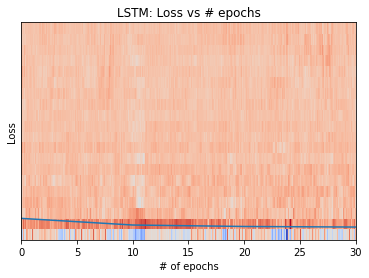

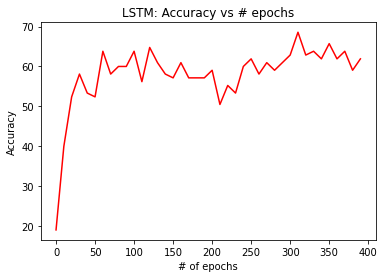

In [17]:
import os
import matplotlib.pyplot as plt
import librosa.display
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, batch_size, output_dim=8, num_layers=2):
        super(LSTM, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.batch_size = batch_size
        self.num_layers = num_layers

        # setup LSTM layer
        self.lstm = nn.LSTM(self.input_dim, self.hidden_dim, self.num_layers)

        # setup output layer
        self.linear = nn.Linear(self.hidden_dim, output_dim)

    def forward(self, input, hidden=None):
        # lstm step => then ONLY take the sequence's final timetep to pass into the linear/dense layer
        # Note: lstm_out contains outputs for every step of the sequence we are looping over (for BPTT)
        # but we just need the output of the last step of the sequence, aka lstm_out[-1]
        lstm_out, hidden = self.lstm(input, hidden)
        logits = self.linear(lstm_out[-1])              # equivalent to return_sequences=False from Keras
        genre_scores = F.log_softmax(logits, dim=1)
        return genre_scores, hidden

    def get_accuracy(self, logits, target):
        """ compute accuracy for training round """
        corrects = (
                torch.max(logits, 1)[1].view(target.size()).data == target.data
        ).sum()
        accuracy = 100.0 * corrects / self.batch_size
        return accuracy.item()

def main():

    train_X = torch.from_numpy(genre_features_mfcc.train_X).type(torch.Tensor)
    dev_X = torch.from_numpy(genre_features_mfcc.dev_X).type(torch.Tensor)
    test_X = torch.from_numpy(genre_features_mfcc.test_X).type(torch.Tensor)

    # Targets is a long tensor of size (N,) which tells the true class of the sample.
    train_Y = torch.from_numpy(genre_features_mfcc.train_Y).type(torch.LongTensor)
    dev_Y = torch.from_numpy(genre_features_mfcc.dev_Y).type(torch.LongTensor)
    test_Y = torch.from_numpy(genre_features_mfcc.test_Y).type(torch.LongTensor)

    # Convert {training, test} torch.Tensors
    print("Training X shape: " + str(genre_features_mfcc.train_X.shape))
    print("Training Y shape: " + str(genre_features_mfcc.train_Y.shape))
    print("Validation X shape: " + str(genre_features_mfcc.dev_X.shape))
    print("Validation Y shape: " + str(genre_features_mfcc.dev_Y.shape))
    print("Test X shape: " + str(genre_features_mfcc.test_X.shape))
    print("Test Y shape: " + str(genre_features_mfcc.test_Y.shape))

    genre_features_mfcc.MFCC_Chrimagram_Figure()

    batch_size = 35  # num of training examples per minibatch
    num_epochs = 400
    global model_mfcc
    # Define model
    print("Build LSTM RNN model ...")
    model_mfcc = LSTM(
        input_dim=14, hidden_dim=128, batch_size=batch_size, output_dim=8, num_layers=2
    )
    loss_function = nn.NLLLoss()  # expects ouputs from LogSoftmax

    optimizer = optim.Adam(model_mfcc.parameters(), lr=0.001)

    # To keep LSTM stateful between batches, you can set stateful = True, which is not suggested for training
    stateful = False

    train_on_gpu = torch.cuda.is_available()
    if train_on_gpu:
        print("\nTraining on GPU")
    else:
        print("\nNo GPU, training on CPU")

    # all training data (epoch) / batch_size == num_batches (12)
    num_batches = int(train_X.shape[0] / batch_size)
    num_dev_batches = int(dev_X.shape[0] / batch_size)

    val_loss_list, val_accuracy_list, epoch_list = [], [], []

    print("Training ...")
    for epoch in range(num_epochs):

        train_running_loss, train_acc = 0.0, 0.0

        # Init hidden state - if you don't want a stateful LSTM (between epochs)
        hidden_state = None
        for i in range(num_batches):

            # zero out gradient, so they don't accumulate btw batches
            model_mfcc.zero_grad()

            # train_X shape: (total # of training examples, sequence_length, input_dim)
            # train_Y shape: (total # of training examples, # output classes)
            #
            # Slice out local minibatches & labels => Note that we *permute* the local minibatch to
            # match the PyTorch expected input tensor format of (sequence_length, batch size, input_dim)
            X_local_minibatch, y_local_minibatch = (
                train_X[i * batch_size: (i + 1) * batch_size, ],
                train_Y[i * batch_size: (i + 1) * batch_size, ],
            )

            # Reshape input & targets to "match" what the loss_function wants
            X_local_minibatch = X_local_minibatch.permute(1, 0, 2)

            # NLLLoss does not expect a one-hot encoded vector as the target, but class indices
            y_local_minibatch = torch.max(y_local_minibatch, 1)[1]

            y_pred, hidden_state = model_mfcc(X_local_minibatch, hidden_state)  # forward pass

            # Stateful = False for training. Do we go Stateful = True during inference/prediction time?
            if not stateful:
                hidden_state = None
            else:
                h_0, c_0 = hidden_state
                h_0.detach_(), c_0.detach_()
                hidden_state = (h_0, c_0)

            loss = loss_function(y_pred, y_local_minibatch)  # compute loss
            loss.backward()  # backward pass
            optimizer.step()  # parameter update

            train_running_loss += loss.detach().item()  # unpacks the tensor into a scalar value
            train_acc += model_mfcc.get_accuracy(y_pred, y_local_minibatch)

        print(
            "Epoch:  %d | NLLoss: %.4f | Train Accuracy: %.2f"
            % (epoch, train_running_loss / num_batches, train_acc / num_batches)
        )

        if epoch % 10 == 0:
            print("Validation ...")  # should this be done every N=10 epochs
            val_running_loss, val_acc = 0.0, 0.0

            # Compute validation loss, accuracy. Use torch.no_grad() & model.eval()
            with torch.no_grad():
                model_mfcc.eval()

                hidden_state = None
                for i in range(num_dev_batches):
                    X_local_validation_minibatch, y_local_validation_minibatch = (
                        dev_X[i * batch_size: (i + 1) * batch_size, ],
                        dev_Y[i * batch_size: (i + 1) * batch_size, ],
                    )
                    X_local_minibatch = X_local_validation_minibatch.permute(1, 0, 2)
                    y_local_minibatch = torch.max(y_local_validation_minibatch, 1)[1]

                    y_pred, hidden_state = model_mfcc(X_local_minibatch, hidden_state)
                    if not stateful:
                        hidden_state = None

                    val_loss = loss_function(y_pred, y_local_minibatch)

                    val_running_loss += (
                        val_loss.detach().item()
                    )  # unpacks the tensor into a scalar value
                    val_acc += model_mfcc.get_accuracy(y_pred, y_local_minibatch)

                model_mfcc.train()  # reset to train mode after iterationg through validation data
                print(
                    "Epoch:  %d | NLLoss: %.4f | Train Accuracy: %.2f | Val Loss %.4f  | Val Accuracy: %.2f"
                    % (
                        epoch,
                        train_running_loss / num_batches,
                        train_acc / num_batches,
                        val_running_loss / num_dev_batches,
                        val_acc / num_dev_batches,
                    )
                )

            epoch_list.append(epoch)
            val_accuracy_list.append(val_acc / num_dev_batches)
            val_loss_list.append(val_running_loss / num_dev_batches)

    # visualization loss
    plt.plot(epoch_list, val_loss_list)
    plt.xlabel("# of epochs")
    plt.ylabel("Loss")
    plt.title("LSTM: Loss vs # epochs")
    plt.show()

    # visualization accuracy
    plt.plot(epoch_list, val_accuracy_list, color="red")
    plt.xlabel("# of epochs")
    plt.ylabel("Accuracy")
    plt.title("LSTM: Accuracy vs # epochs")
    # plt.savefig('graph.png')
    plt.show()


if __name__ == "__main__":
    main()

## (e) Try a customized music

In [ ]:
# TODO: implement inference